In [1]:
### Import statements
# For Latin Hypercube Sampling
from pyDOE2 import *
# For GP surrogates
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern
from math import pi, cos, radians
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

## Analytical Model
Based on the Buckling Differential Equation for a plate

In [2]:
### Analytical Model
def Pcr_Analytical(x,l,w,t,E_f,n_eigen):
    r_f = x[0] # in mm
    theta_f = x[1] # in degrees
    E_m = x[2] # in GPa
    #m = 1
    #n = 1
    P_cr = []
    poisson_ratio = 0.3
    v_f = volume_fraction(l,w,t,x)
    ## Rule of Mixtures
    E_effective = (E_f*v_f + (1-v_f)*E_m)*1e3 # Converting to N/mm^2
    D = E_effective*t**3/(12*(1-poisson_ratio**2)) # Flexural Rigidity
    for i in range(n_eigen):
        m = i+1
        n = 1
        P_cr.append(D*(pi*l/m)**2*((m/l)**2+(n/w)**2)**2)
    return P_cr
    
### Volume Fraction
def volume_fraction(length,width,thickness,x_design):
    r_f = x_design[0]
    theta_f = x_design[1]
    v_total = length*width*thickness
    l_fibre_shortest = length/(6*cos(radians(theta_f)))
    l_fibre_med = 2*l_fibre_shortest
    l_fibre_longest = 3*l_fibre_shortest
    vol_fibres = pi*(r_f**2)*(2*l_fibre_shortest + 2*l_fibre_med + l_fibre_longest)
    vol_total = length*width*thickness
    vol_frac = vol_fibres/vol_total
    return vol_frac

## Generate Training Dataset
- Latin Hypercube Sampling is used to generate uniformly distributed samples.
- Each generated dataset is checked for satisfaction of the volume fraction constraint.
- NOTE: There is no random seed argument for Latin Hypercube Sampling Function "lhs". Therefore rerunning the cell will provide a different set of design samples. An email was sent to the author to clarify this, but no response was received. 

7072


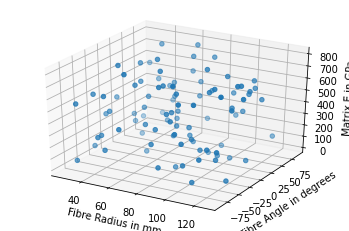

In [3]:
### Define the number of designs for Neural Network training (DO NOT Run Again!)
n_train = 100

### Define maximum limit for volume fraction
vf_limit = 0.5

### Define the Problem Constants
l_matrix = 3048 # in mm
w_matrix = l_matrix # in mm
t_matrix = 254 # in mm
E_fibre = 350 # in GPa

### Define the input design parameter limits
Em_upper_limit = 800 # in GPa
Em_lower_limit = 10 # in GPa

rf_upper_limit = t_matrix/2 # in mm
rf_lower_limit = 25 # in mm

theta_f_upper_limit = 90 # in deg
theta_f_lower_limit = -90 # in deg

### Forming Gaussian Process Surrogate
def project(x, Em_lower_limit, Em_upper_limit, rf_lower_limit, rf_upper_limit, theta_f_lower_limit, theta_f_upper_limit,):
    # x = [rf, theta_f, Em] * n_train
    rf_projected = x[:,0]*(rf_upper_limit-rf_lower_limit) + rf_lower_limit
    theta_f_projected = x[:,1]*(theta_f_upper_limit-theta_f_lower_limit) + theta_f_lower_limit
    Em_projected = x[:,2]*(Em_upper_limit-Em_lower_limit) + Em_lower_limit
    x_projected = np.vstack((rf_projected, theta_f_projected, Em_projected)).T
    return x_projected

conv = False
n_iter = 0
while(not conv):
    x_train = lhs(3, samples=n_train, criterion='maximin')
    x_train_proj = project(x_train, Em_lower_limit, Em_upper_limit, rf_lower_limit, rf_upper_limit, theta_f_lower_limit, theta_f_upper_limit)    
    for i in range(n_train):
        v_f = volume_fraction(l_matrix, w_matrix, t_matrix, x_train_proj[i,:])
        if (v_f>vf_limit):
            break
        elif (i==n_train-1):
            conv = True
    n_iter = n_iter + 1
    
#print(x_train_proj)
print(n_iter)

### Plotting the sampled datapoints
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x_train_proj[:,0], x_train_proj[:,1], x_train_proj[:,2],marker='o')
ax.set_xlabel('Fibre Radius in mm')
ax.set_ylabel('Fibre Angle in degrees')
ax.set_zlabel('Matrix E in GPa')
fig.savefig('lhs_sampling.png')

## Create Gaussian Process Surrogate and plot mean and standard deviation
- The generated training dataset is used to train a Gaussian Process Surrogate
- The Scikit Learn library is used for this purpose
- The mean and standard deviation for the surrogate model at uniformly spaced points in the fibre radius and fibre angle meshgrid is plotted for three constant values of matrix Young's Modulus (10, 405 and 800 GPa)
- Note: The cell is run with multiple custom_kernel functions (one-at-a-time) for the same set of generated LHS samples to compare their ability to capture complex correlations between the datapoints

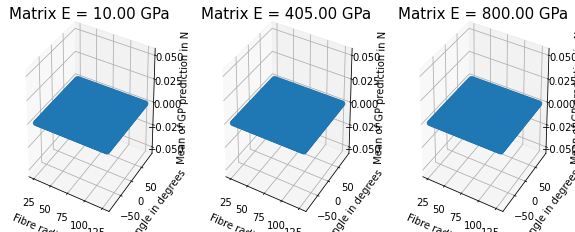

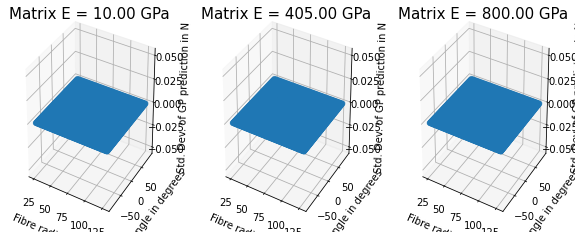

In [7]:
### Create the Gaussian Process Regressor
n_eigen = 1 # Number of requested Buckling Eigen Values
len_scale = [rf_upper_limit, theta_f_upper_limit, Em_upper_limit] # only for RBF(length_scale) line
y_analytical = np.zeros([n_train,n_eigen])
for i in range(n_train):
    y_analytical[i,:] = Pcr_Analytical(x_train_proj[i,:],l_matrix,w_matrix,t_matrix,E_fibre,n_eigen)
custom_kernel = RBF(length_scale=len_scale)
#custom_kernel = RBF()
#custom_kernel = DotProduct() + WhiteKernel()
#custom_kernel = Matern()
gp_analytical = GaussianProcessRegressor(kernel=custom_kernel,random_state=0).fit(x_train_proj, y_analytical)

### Plot mean and variance of gaussian process 
n_datapoints = 100

def GP_prediction_mean(r_f, theta_f, E_m):
    x_vec = np.array([r_f, theta_f, E_m]).reshape(1,-1)
    y_mean = gp_analytical.predict(x_vec)
    return y_mean

def GP_prediction_std(r_f, theta_f, E_m):
    x_vec = np.array([r_f, theta_f, E_m]).reshape(1,-1)
    [y_mean, y_std] = gp_analytical.predict(x_vec, return_std=True)
    return y_std

r_fib_arr = np.linspace(rf_lower_limit, rf_upper_limit, n_datapoints)
theta_fib_arr = np.linspace(theta_f_lower_limit, theta_f_upper_limit, n_datapoints)

r_fib_vec, theta_fib_vec = np.meshgrid(r_fib_arr, theta_fib_arr)
E_m_vals = [Em_lower_limit, (Em_lower_limit + Em_upper_limit)/2, Em_upper_limit]
num_subplots = len(E_m_vals)

### Plot mean of GP
fig = plt.figure(figsize=(10,4))
for i,Em in enumerate(E_m_vals):
    r_fib = []
    theta_fib = []
    Pcr_mean = []
    for j in range(n_datapoints):
        for k in range(n_datapoints):
            r_fib.append(r_fib_vec[k,j])
            theta_fib.append(theta_fib_vec[k,j])
            Pcr_curr = GP_prediction_mean(r_fib_vec[k,j], theta_fib_vec[k,j], Em)
            Pcr_mean.append(Pcr_curr[0])
    ax = fig.add_subplot(1, num_subplots, i+1, projection='3d')
    ax.scatter3D(r_fib, theta_fib, Pcr_mean)
    ax.set_xlabel('Fibre radius in mm')
    ax.set_ylabel('Fibre angle in degrees')
    ax.set_zlabel('Mean of GP prediction in N')
    ax.set_title('Matrix E = %.2f GPa'%Em, fontsize=15)
fig.savefig('GP_analytical_mean.png')
    
### Plot std of GP
fig = plt.figure(figsize=(10,4))
for i,Em in enumerate(E_m_vals):
    r_fib = []
    theta_fib = []
    Pcr_std = []
    for j in range(n_datapoints):
        for k in range(n_datapoints):
            r_fib.append(r_fib_vec[k,j])
            theta_fib.append(theta_fib_vec[k,j])
            Pcr_curr_std = GP_prediction_std(r_fib_vec[k,j], theta_fib_vec[k,j], Em)
            Pcr_std.append(Pcr_curr_std[0])
    ax = fig.add_subplot(1, num_subplots, i+1, projection='3d')
    ax.scatter3D(r_fib, theta_fib, Pcr_mean)
    ax.set_xlabel('Fibre radius in mm')
    ax.set_ylabel('Fibre angle in degrees')
    ax.set_zlabel('Std. Dev. of GP prediction in N')
    ax.set_title('Matrix E = %.2f GPa'%Em, fontsize=15)
fig.savefig('GP_analytical_std.png')